In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
import re
from datetime import datetime
import json
from qwikidata.entity import WikidataItem, WikidataLexeme, WikidataProperty
from qwikidata.linked_data_interface import get_entity_dict_from_api

# Abstract

Have you ever wondered why some actors keep getting cast in the same role? Why Dwayne Johnson always seems to plays the adventurous, headstrong and caring leader? Why Jason Staham is constantly cast as the gritty, hardboiled tough guy? Do these physical characteristics lead to success? <br>
This is called typecasting, the process by which an actor becomes strongly identified with particular roles, or characters having the same traits or coming from the same social or ethnic groups. We want to analyse the physical aspects of typecasting, by decoding the DNA of the characters on the silver screen throughout time and genres, before associating the findings to the movie's success. <br>
<br>
We want to identify and observe the physical trends of actors playing the same role, and see them evolve over time, using an facial image analysis dataset named CelebA, in addition to the CMU Movie Summary Corpus. This analysis will eventually lead us to the question: <br>
***What role would you be typecasted in?***

### Project Plotline

#### 1) Movies and Characters MetaData 
We are given a series of datasets in this corpus, with the metadata and tv tropes cluster being the data of most interest for us. This metadata is comprised of two dataframes, the movie metadata and the characters metadata. As indicated in the CMU Movie Summary Corpus ReadMe, these two dataframes have a many variables. Let us first identify the variables of interest for our story. <br>
##### a) Identifying our variables of interests
+ Movie metadata: *Wiki_movieID, Movie Name, Release Date, Box Office, Genres* <br>
+ Character metadata: *Wiki_movieID, Release Date, Character Name, Gender, Height, Ethinicity, Actor Name, Age at Movie Release* <br>
##### b) Cleaning and sorting our data
+ We then pre-process the dataframes:
    + We sort our movies dataframe by decades of release date.
    + We also sort our movies by genres before plotting the number of movies by genre to identify the most prevalent ones.
    + We first identify the percentage of missing data in each of our variables of interest as well as check for any errors *(such as a movie released in 1010 rather than 2010)*.
    + The genres and decades of release are added as variables to our movie metadata.
    + Our character metadata is merged with the movie metadata, correctly associating the characters and actors to their respective genres and decades of release.
#### 2) TV Tropes
A notable missing element of our character metadata is the classification of the characters in the role they play for their respective stories *(honorable hero, sympathetic villain, antihero....)*. As such, as we want to associate our actors to their roles, we use the TV tropes data, defined as a txt file named tvtropes.clusters.txt. <br>
As such, we add this dataset to our project and pre-process it, as we did with the movies and characters dataframe. 

#### 3) CelebA - Facial Image Analysis
Identification of physical elements would not be complete without analysis of the facial image of the actors. Do charismatic and headstrong protagonists share similarities in the shape of their jawline or in the colour of their eyes? <br>
We want to quantify the different elements of a face using machine learning before using said data to compare actors to each other, in the hope of observing ressemblances and trends between actors playing the similar character roles. Thankfully, we found a dataset, CelebA, that already quantified the different characteristics of actors' faces. <br>
Let us add it to our project and pre-process it.

## 1) Movie and Characters MetaData

### 1.a) Loading Data and identifying variables of interest

In [2]:
#Loading our data
characters_df = pd.read_csv('data/character.metadata.tsv', delimiter="\t", 
                            names=['Wiki_movieID', 'Freebase_movieID', 'ReleaseDate', 'CharacterName', 'ActorDOB', 'ActorGender', 'ActorHeight', 'ActorEthnicity', 'ActorName', 'ActorAge', 'Freebase_charactermap', 'Freebase_characterID', 'Freebase_actorID'])
movies_df = pd.read_csv('data/movie.metadata.tsv', delimiter="\t", 
                        names=['Wiki_movieID', 'Freebase_movieID', 'MovieName', 'ReleaseDate', 'BoxOffice', 'Runtime', 'Languages', 'Countries', 'Genres'])

#We look at the length and shape of our initial dataframes.
print("Size of 'Characters' DataFrame: %d" % len(characters_df))
print("Size of 'Movies' DataFrame: %d" % len(movies_df))

print("Shape of 'Characters' DataFrame: %d" % characters_df.shape[1])
print("Shape of 'Movies' DataFrame: %d" % movies_df.shape[1])

Size of 'Characters' DataFrame: 450669
Size of 'Movies' DataFrame: 81741
Shape of 'Characters' DataFrame: 13
Shape of 'Movies' DataFrame: 9


In [3]:
movies_df.head()

,Wiki_movieID,Freebase_movieID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
characters_df.head()

,Wiki_movieID,Freebase_movieID,ReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAge,Freebase_charactermap,Freebase_characterID,Freebase_actorID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


As noted above, we identify the variables of interest for our project.
+ Movie metadata: *WikiID, Movie Name, Release Date, Genres* <br>
+ Character metadata: *WikiID, Release Date, Character Name, Gender, Height, Ethinicity, Actor Name, Age at Movie Release* <br>

### 1.b) Cleaning and Sorting our Data

In [5]:
#Functions
def percentage_missingdata(dataframe, column_name):
    notmissing = dataframe[column_name].count()
    totaldata = len(dataframe[column_name])
    percentage_missing = (1 - (notmissing/totaldata)) * 100
    
    return percentage_missing

def is_valid_date(date_string, format_string):
    try:
        datetime.strptime(date_string, format_string)
        return True
    except ValueError:
        return False

In [6]:
#change the {} into NaNs
movies_df.replace({'{}': pd.NA}, inplace=True)
characters_df.replace({'{}': pd.NA}, inplace=True)

#### 1.b.i) Sorting and Visualising our Movie Dataframe

##### a) Decades of Release

In [7]:
#We start by classifying our data per decades of release dates.
#Keeping only the year of release of the movies to classify them by decades
format1 = "%Y-%m-%d"
format2 = "%Y-%m"

for y in range(0,len(movies_df)):
    if isinstance(movies_df['ReleaseDate'][y], str):
        if is_valid_date(movies_df['ReleaseDate'][y],format1):
            date_obj = datetime.strptime(movies_df['ReleaseDate'][y], "%Y-%m-%d")
            movies_df.loc[y,'ReleaseDate'] = date_obj.year
            
    if isinstance(movies_df['ReleaseDate'][y], str):
        if is_valid_date(movies_df['ReleaseDate'][y],format2):
            date_obj = datetime.strptime(movies_df['ReleaseDate'][y], "%Y-%m")
            movies_df.loc[y,'ReleaseDate'] = date_obj.year
            
movies_df['ReleaseDate'] = movies_df['ReleaseDate'].astype(float)

In [8]:
#we notice an error in the movies dataset. The movie 'Hunting Season' is said to have a release date in 1010. This is impossible
#A quick google search reveals that the movie release year was 2010. Let us fix that.
huntingseason_error = movies_df.loc[movies_df['MovieName'] == 'Hunting Season'].index
movies_df.loc[huntingseason_error,'ReleaseDate'] = 2010.0

movies_df.sort_values(by='ReleaseDate', ascending=True, inplace=True)

In [9]:
#Classifying movies by decades. 
#We only have two movies before 1890s decade, released in 1888 and 1889. Let us include them in 1890s decade.
_1890s = movies_df.query('ReleaseDate < 1900.0')
_1900s = movies_df.query('ReleaseDate >= 1900.0 and ReleaseDate < 1910.0')
_1910s = movies_df.query('ReleaseDate >= 1910.0 and ReleaseDate < 1920.0')
_1920s = movies_df.query('ReleaseDate >= 1920.0 and ReleaseDate < 1930.0')
_1930s = movies_df.query('ReleaseDate >= 1930.0 and ReleaseDate < 1940.0')
_1940s = movies_df.query('ReleaseDate >= 1940.0 and ReleaseDate < 1950.0')
_1950s = movies_df.query('ReleaseDate >= 1950.0 and ReleaseDate < 1960.0')
_1960s = movies_df.query('ReleaseDate >= 1960.0 and ReleaseDate < 1970.0')
_1970s = movies_df.query('ReleaseDate >= 1970.0 and ReleaseDate < 1980.0')
_1980s = movies_df.query('ReleaseDate >= 1980.0 and ReleaseDate < 1990.0')
_1990s = movies_df.query('ReleaseDate >= 1980.0 and ReleaseDate < 2000.0')
_2000s = movies_df.query('ReleaseDate >= 2000.0 and ReleaseDate < 2010.0')
_2010s = movies_df.query('ReleaseDate >= 2010.0 and ReleaseDate < 2020.0')

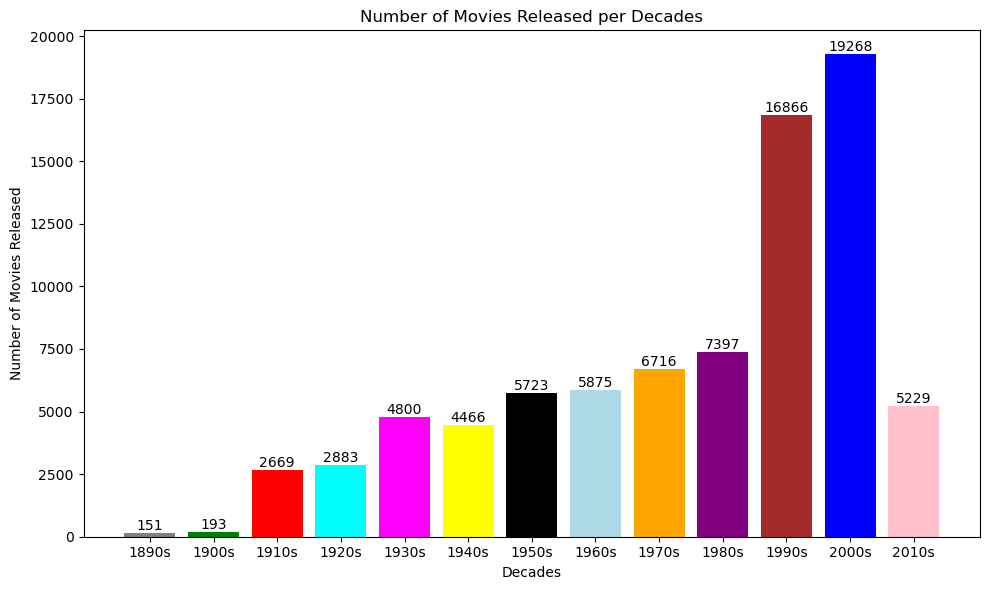

In [10]:
#We can plot the number of movies released per decades

movies_decades_data = {'Decades': ['1890s', '1900s', '1910s', '1920s', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s'],
                        'Number of Movies Released': [len(_1890s), len(_1900s), len(_1910s), len(_1920s), len(_1930s), len(_1940s), len(_1950s),
                                                     len(_1960s), len(_1970s), len(_1980s), len(_1990s), len(_2000s), len(_2010s)]}
perdecades_df = pd.DataFrame(movies_decades_data)

plt.figure(figsize=(10,6))
moviedecades_barchart = plt.bar(perdecades_df['Decades'], perdecades_df['Number of Movies Released'], 
        color = ['gray', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'lightblue', 
                 'orange', 'purple', 'brown', 'blue', 'pink'])

for bar in moviedecades_barchart:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 1), ha='center', va='bottom')

plt.xlabel('Decades')
plt.ylabel('Number of Movies Released')
plt.title('Number of Movies Released per Decades')
plt.tight_layout()
plt.show()

##### b) Movie Genres

In [11]:
#Keeping only the name of the genre in our dataframe
genre_names_list = []

for gen in range(len(movies_df)):
    if pd.notna(movies_df['Genres'][gen]) and isinstance(movies_df['Genres'][gen], str):
        genre_dict = json.loads(movies_df['Genres'][gen])
        genre_names = list(genre_dict.values())
        genre_names_list.append(genre_names)
    else:
        genre_names_list.append(pd.NA)

movies_df['Genres'] = genre_names_list

In [12]:
#Flattening all the genres list into one single list
copy = movies_df.copy()
movies_df_exploded = copy.explode('Genres')
movies_df_exploded = movies_df_exploded[movies_df_exploded['Genres'] != '{}']
flattened_list = movies_df_exploded['Genres'].tolist()

genres_counts = Counter(flattened_list)
counts_df = pd.DataFrame.from_dict(genres_counts, orient='index', columns=['Count'])

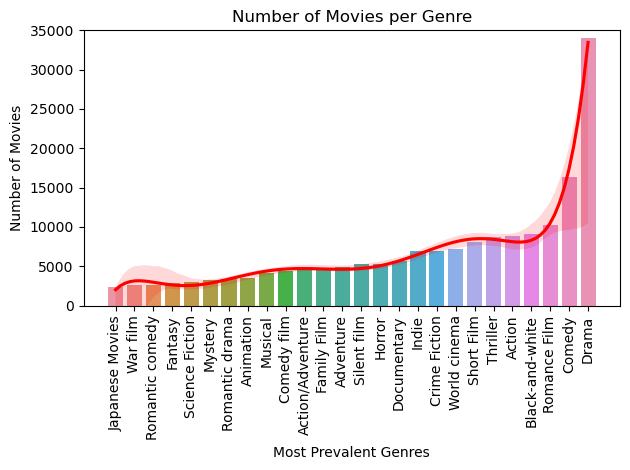

In [13]:
#Plotting movies by genres

#We notice that there's 2294 counts of films with missing genres, characterised by an NaN value. 
#As such we determine our threshold to be over 2300 for the genre occurences.
counts_df = counts_df[counts_df['Count'] >= 2300]

counts_df.sort_values(by='Count', ascending=True, inplace=True)

sns.barplot(x=counts_df.index.tolist(), y=counts_df['Count'])
sns.regplot(x=np.arange(len(counts_df)), y=counts_df['Count'], order=7, scatter=False, color='red')
plt.xticks(rotation=90)
plt.ylim(bottom=0, top=35000)
plt.xlabel('Most Prevalent Genres')
plt.ylabel('Number of Movies')
plt.title('Number of Movies per Genre')
plt.tight_layout()
plt.show()

##### c) Box Office Revenue

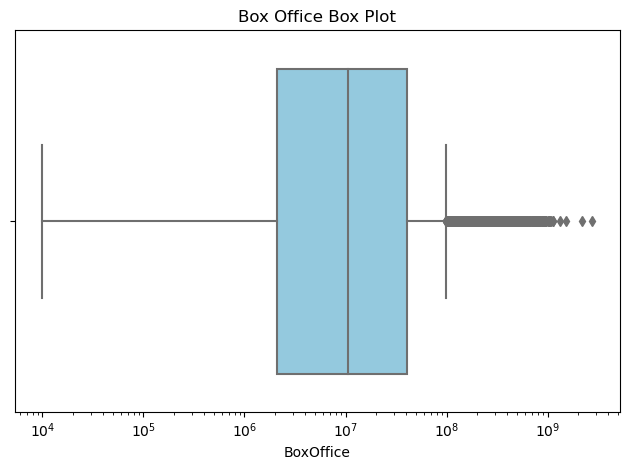

In [14]:
sns.boxplot(x=movies_df['BoxOffice'],  color='skyblue')
plt.xscale('log')
plt.title('Box Office Box Plot')
plt.tight_layout()
plt.show()

> We observe a large distribution for our Box Office numbers, with a large number of extreme outliers.

#### 1.b.ii) Checking the percentage of missing data for each variable of interest

In [15]:
#Missing data in movies_df
movie_variables = ['Wiki_movieID', 'MovieName', 'ReleaseDate','Genres', 'BoxOffice']
percentage_missing_movies = []

for v in range(0, len(movie_variables)):
    percentage_missing_movies.append(percentage_missingdata(movies_df, movie_variables[v]))
    
missing_data_movies_df = pd.DataFrame({'Variables of Interest': movie_variables,
                                           'Percentage of Missing Data': percentage_missing_movies})  


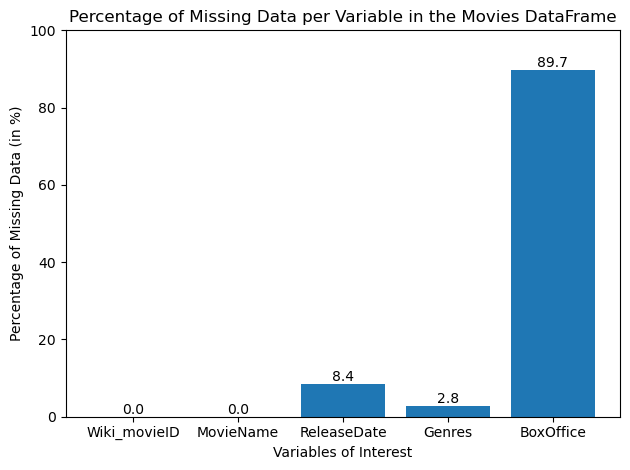

In [16]:
#Plotting the percentage of missing data for the variables of movies_df
bars = plt.bar(missing_data_movies_df['Variables of Interest'], missing_data_movies_df['Percentage of Missing Data'])
plt.ylim(0, 100)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 1), ha='center', va='bottom')

plt.xlabel('Variables of Interest')
plt.ylabel('Percentage of Missing Data (in %)')
plt.title('Percentage of Missing Data per Variable in the Movies DataFrame')
plt.tight_layout()
plt.show()

>We notice that we have very low percentages of missing data for our variables of interest. <br>
>We have 0% of missing data for both our Wiki_movieID and Movie Name, as such we can associate each movie to its respective Wikipedia Page using WikiData without any errors.<br>
>We have 8.4% of missing data for Release Date variable and 2.8% for Genres variable. These values are both very low and under 10%. Generally, when we have more than 10% of missing data, our data is likely to be biased. As such this is not the case for these two variables.<br>
>We see however 89.7% of missing data for the BoxOffice variable, an astonishing amount. This will mean that our BoxOffice is very likely to be biased towards the movies that have a BoxOffice value.<br>

In [17]:
#Missing data in characters_df
character_variables = ['Wiki_movieID', 'ReleaseDate', 'CharacterName','ActorGender', 'ActorHeight', 
                                                    'ActorEthnicity', 'ActorName', 'ActorAge','ActorDOB']
percentage_missing_characters = []

for var in range(0, len(character_variables)):
    percentage_missing_characters.append(percentage_missingdata(characters_df, character_variables[var]))

missing_data_characters_df = pd.DataFrame({'Variables of Interest': character_variables,
                                           'Percentage of Missing Data': percentage_missing_characters})                                                                                                                             

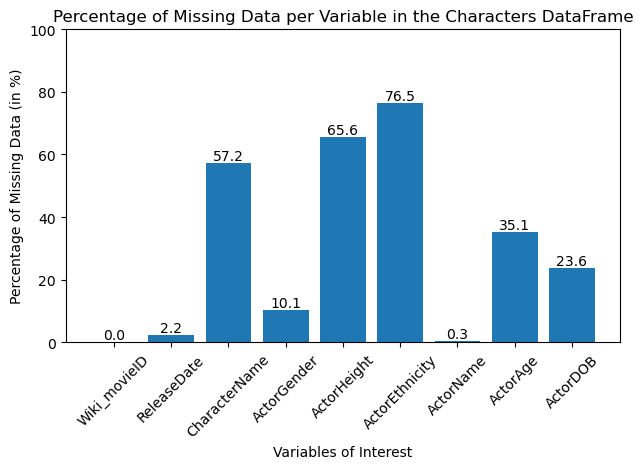

In [18]:
#Plotting the percentage of missing data for the variables of characters_df
bars = plt.bar(missing_data_characters_df['Variables of Interest'], missing_data_characters_df['Percentage of Missing Data'])
plt.ylim(0, 100)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 1), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.xlabel('Variables of Interest')
plt.ylabel('Percentage of Missing Data (in %)')
plt.title('Percentage of Missing Data per Variable in the Characters DataFrame')
plt.tight_layout()
plt.show()

> Contrarily to movies_df, we observe a much higher percentage of missing data for our respective variables of interest, the notable ones being *CharacterName*, *ActorHeight*, *ActorEthnicity* and *ActorDOB*, *ActorAge*.<br>
> For character name, this missing data is to be expected as many characters in movies do not have names, as they are mere background characters. The character roles that they fill are much more interesting for our analysis. <br>
> Similarly, the missing data in actor age and actor date of birth (DOB) is not an issue as we can use either one or the other variable to calculate the actor's age. Cleaning this part of the data, we should recalculate the percentage of missing data for actor age. <br>
> Our biggest concern is with the large quantity of missing data in both actor height and ethnicity as they are both key aspects to our project idea. Indeed, it would be particularly interesting to observe if ethnicity is a significant factor in typecasting. How can we solve this issue? An idea would be to find an external dataset that completes our own.

#### 1.b.iii) Adding Decades Variable to the Movie DataFrame

In [19]:
#This function returns the decade of the movie's release date.
def get_decade(year):
    return (year // 10) * 10

In [20]:
#Let us start by adding the decades to movies_df
if 'Decade' not in movies_df.columns:
    movies_df.insert(5, 'Decade', None)

In [21]:
for dec in range(len(movies_df)):
    movies_df.loc[dec, 'Decade'] = get_decade(movies_df['ReleaseDate'][dec])

In [22]:
#As said earlier, we add the two movies released in 1888 and 1889 to the 1890s decades. 
decade_change1 = movies_df.loc[movies_df['ReleaseDate'] == 1888].index
movies_df.loc[decade_change1,'Decade'] = 1890.0

decade_change2 = movies_df.loc[movies_df['ReleaseDate'] == 1889].index
movies_df.loc[decade_change2,'Decade'] = 1890.0

#### 1.b iv) Converting the ethnicity from keys to usable words using wikidata

In [23]:
from SPARQLWrapper import SPARQLWrapper, JSON

def get_ethnicity(freebase_id):
    """get the label of the freebase ID from Wikidata
    Args:
        freebase_id: the freebase ID to be decoded
    Returns: 
        entity.label, the corresponding label of the Wikidata ID
    """
    endpoint_url = "https://query.wikidata.org/sparql"
    query = """
    SELECT ?item ?itemLabel WHERE {
      ?item wdt:P646 '""" + freebase_id + """'.
      SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
    }
    """
    sparql = SPARQLWrapper(endpoint_url)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    
    try:
        results = sparql.query().convert()
        if results["results"]["bindings"]:
            label = results["results"]["bindings"][0]["itemLabel"]["value"]
            return label
        else:
            return "Label not found for the specified Freebase ID"
    except Exception as e:
        return np.nan

In [24]:
# groups by ethnicity, to get all the different ethnicities in one table
temp_df = characters_df['ActorEthnicity'].groupby(characters_df['ActorEthnicity']).agg(['count'])
temp_df = temp_df.reset_index()
temp_df

,ActorEthnicity,count
0,/m/01267,10
1,/m/012c1l,141
2,/m/012f86,32
3,/m/012fh,1
4,/m/01336l,224
...,...,...
474,/m/0j4w_,43
475,/m/0j6x8,43
476,/m/0x67,10159
477,/m/0xff,5


In [25]:
#Match every freebase ethnicity ID to the ethnicity, if it found in Wikidata
temp_temp_df = temp_df.copy()
et = []
for i in range(len(temp_df['ActorEthnicity'])):
    df_temp_ethnicity = temp_df.iloc[i:i+1]
    for ethnicity in df_temp_ethnicity['ActorEthnicity'] :
        eth_tra = get_ethnicity(ethnicity)
        j = 0
        while ((type(eth_tra) == float) & (j<100)):
            #print(type(get_ethnicity(ethnicity)))
            eth_tra = get_ethnicity(ethnicity)
            j += 1
        et.append(eth_tra)

NameError: name 'get_entity_label' is not defined

In [96]:
temp_temp_df['Actor ethnicity'] = et
print(get_ethnicity(temp_df['ActorEthnicity'][29]))

Label not found for the specified Freebase ID


In [97]:
#convert to string every ethnicity taken from Wikidata
tmp = []
for i in range (len(temp_temp_df['Actor ethnicity'])):
    if not (pd.isna(temp_temp_df['Actor ethnicity'][i])):
        tmp.append(str(temp_temp_df['Actor ethnicity'][i]))
    else:
        tmp.append(temp_temp_df['Actor ethnicity'][i])
temp_temp_df['Actor ethnicity'] = tmp
temp_temp_df

,ActorEthnicity,count,Actor ethnicity
0,/m/01267,10,Albanians
1,/m/012c1l,141,French Canadians
2,/m/012f86,32,Ukrainians
3,/m/012fh,1,Afrikaners
4,/m/01336l,224,Asian Americans
...,...,...,...
474,/m/0j4w_,43,Croats
475,/m/0j6x8,43,Indigenous Australians
476,/m/0x67,10159,African Americans
477,/m/0xff,5,Arabs


In [111]:
frequency_ethnicity = temp_temp_df.sort_values(by=['count'])
frequency_ethnicity

#gin people -> vietnamese 
# koryo saram -> corean

english_df = temp_temp_df[temp_temp_df['Actor ethnicity'].str.contains('English', case=False, na=False)]
english_df

french_df = temp_temp_df[temp_temp_df['Actor ethnicity'].str.contains('French', case=False, na=False)]
french_df


,ActorEthnicity,count,Actor ethnicity
1,/m/012c1l,141,French Canadians
110,/m/02qv716,3,French-speaking Quebecer
181,/m/03ts0c,1350,French
224,/m/04dzwby,15,French Chilean
305,/m/06v41q,300,French Americans


#### 1.b.v) Merging Movie and Character DataFrames

In [27]:
characters_movies_df = characters_df.merge(movies_df, on=['Wiki_movieID'], how = 'left', suffixes=("", "_y")).drop(['Freebase_movieID_y', 'ReleaseDate_y'], axis=1)
characters_movies_df.head()

,Wiki_movieID,Freebase_movieID,ReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAge,Freebase_charactermap,Freebase_characterID,Freebase_actorID,MovieName,BoxOffice,Decade,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,Ghosts of Mars,14010832.0,2000.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",[Action]
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,Ghosts of Mars,14010832.0,2000.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",[Action]
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,Ghosts of Mars,14010832.0,2000.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",[Action]
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,Ghosts of Mars,14010832.0,2000.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",[Action]
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,Ghosts of Mars,14010832.0,2000.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",[Action]


In [28]:
#Counting the number of characters per movie genre
characters_movies_copy = characters_movies_df.copy()
c_m_exploded = characters_movies_copy.explode('Genres')
c_m_exploded = c_m_exploded[c_m_exploded['Genres'] != '{}']
flat_list = c_m_exploded['Genres'].tolist()

charac_counts = Counter(flat_list)
charac_counts_df = pd.DataFrame.from_dict(charac_counts, orient='index', columns=['Count'])

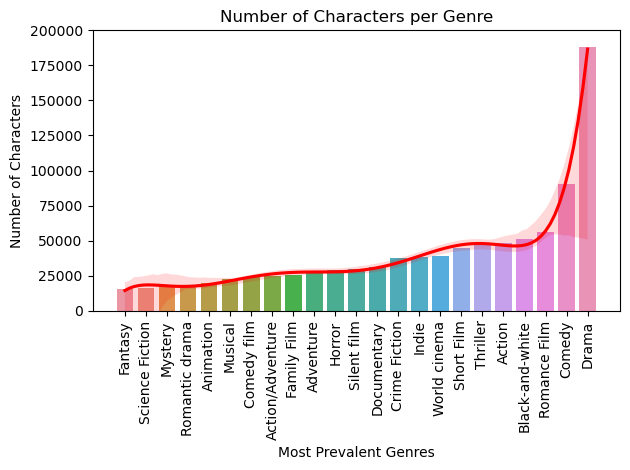

In [29]:
charac_counts_df = charac_counts_df[charac_counts_df['Count'] >= 15000]

charac_counts_df.sort_values(by='Count', ascending=True, inplace=True)

sns.barplot(x=charac_counts_df.index.tolist(), y=charac_counts_df['Count'])
sns.regplot(x=np.arange(len(charac_counts_df)), y=charac_counts_df['Count'], order=7, scatter=False, color='red')
plt.xticks(rotation=90)
plt.ylim(bottom=0, top=200000)
plt.xlabel('Most Prevalent Genres')
plt.ylabel('Number of Characters')
plt.title('Number of Characters per Genre')
plt.tight_layout()
plt.show()

### 2) TV Tropes

In [30]:
df_tropes_original = pd.read_csv('data/tvtropes.clusters.txt', delimiter="\t", names=['trope', 'character'])
json_obj = df_tropes_original['character'].apply(json.loads)
df_tropes_norm = pd.json_normalize(json_obj[0])
for i in range(1, len(json_obj)):
    df_norm = pd.json_normalize(json_obj[i])
    df_tropes_norm = pd.concat([df_tropes_norm, df_norm], ignore_index=True)

tropes_df = pd.concat([df_tropes_original.drop('character', axis=1), df_tropes_norm], axis=1)

tropes_df = tropes_df.rename(columns={'id': 'Freebase_charactermap', 'char':'CharacterName', 'actor':'ActorName', 'movie':'MovieName'})
tropes_df

,trope,CharacterName,MovieName,Freebase_charactermap,ActorName
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader
...,...,...,...,...,...
496,young_gun,Morgan Earp,Tombstone,/m/0k776f,Bill Paxton
497,young_gun,Colorado Ryan,Rio Bravo,/m/0k2kqg,Ricky Nelson
498,young_gun,Tom Sawyer,The League of Extraordinary Gentlemen,/m/0k5nsh,Shane West
499,young_gun,William H. 'Billy the Kid' Bonney,Young Guns II,/m/03lrjk0,Emilio Estevez


In [31]:
characters_movies_tropes = characters_movies_df.merge(tropes_df, on=['Freebase_charactermap'], how = 'left', suffixes=("", "_y")).drop(['CharacterName_y', 'MovieName_y','ActorName_y'], axis=1)
characters_movies_tropes


,Wiki_movieID,Freebase_movieID,ReleaseDate,CharacterName,ActorDOB,ActorGender,ActorHeight,ActorEthnicity,ActorName,ActorAge,...,Freebase_characterID,Freebase_actorID,MovieName,BoxOffice,Decade,Runtime,Languages,Countries,Genres,trope
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,/m/0bgcj3x,/m/03wcfv7,Ghosts of Mars,14010832.0,2000.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",[Action],NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,...,/m/0bgchn4,/m/0346l4,Ghosts of Mars,14010832.0,2000.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",[Action],NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,...,/m/0bgchn_,/m/01vw26l,Ghosts of Mars,14010832.0,2000.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",[Action],NaN
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,...,/m/0bgchnq,/m/034hyc,Ghosts of Mars,14010832.0,2000.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",[Action],NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,...,/m/0bgchp9,/m/01y9xg,Ghosts of Mars,14010832.0,2000.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",[Action],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450718,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,...,/m/0kr406h,/m/0b_vcv,The Super Dimension Fortress Macross II: Lover...,NaN,1990.0,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","[Samurai cinema, Japanese Movies, Adventure]",NaN
450719,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,...,/m/0kr4090,/m/0bx7_j,The Super Dimension Fortress Macross II: Lover...,NaN,1990.0,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","[Samurai cinema, Japanese Movies, Adventure]",NaN
450720,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,...,NaN,/m/022g44,Five Clues to Fortune,NaN,1950.0,129.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","[Drama, Political drama, War film]",NaN
450721,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,...,NaN,/m/0g8ngmm,Five Clues to Fortune,NaN,1950.0,129.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","[Drama, Political drama, War film]",NaN


In [32]:
missing_tropes = percentage_missingdata(characters_movies_tropes, 'trope')
print(missing_tropes)

99.88884525528984


### 3) CelebA - Facial Image Analysis

In [ ]:
test